In [138]:
import bambi as bmb
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import numpy as np

In [ ]:
chimps = pd.read_csv('./data/chimpanzees.csv', sep=';')
chimps['treatment'] = 1 + chimps['prosoc_left'] + 2*chimps['condition']

In [ ]:
chimps

In [ ]:
chimps.isna().sum()

In [91]:
model = bmb.Model(
    "pulled_left ~ 0 + (1|actor) + (1|treatment)", 
    family='bernoulli',
    data=chimps
    )

idata = model.fit(inference_method='nuts_blackjax')

Modeling the probability that pulled_left==1


Compiling...
Compilation time =  0:00:00.721701
Sampling...
Sampling time =  0:00:03.181723
Transforming variables...
Transformation time =  0:00:00.397722


In [92]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|actor_sigma,2.250,0.776,1.030,3.677,0.030,0.021,646.0,1306.0,1.01
1|treatment_sigma,0.684,0.432,0.070,1.493,0.015,0.011,806.0,1544.0,1.00
1|actor[1],-0.487,0.390,-1.237,0.222,0.014,0.010,790.0,1404.0,1.01
1|actor[2],4.649,1.364,2.450,7.261,0.035,0.025,1591.0,1927.0,1.00
1|actor[3],-0.790,0.403,-1.525,-0.032,0.014,0.010,888.0,1277.0,1.01
1|actor[4],-0.789,0.398,-1.543,-0.055,0.013,0.010,896.0,1283.0,1.01
1|actor[5],-0.485,0.391,-1.221,0.267,0.013,0.009,918.0,1401.0,1.01
1|actor[6],0.453,0.395,-0.331,1.140,0.014,0.010,814.0,1257.0,1.01
1|actor[7],1.969,0.482,1.050,2.862,0.014,0.010,1131.0,1450.0,1.01
1|treatment[1],-0.010,0.352,-0.631,0.683,0.013,0.009,738.0,1242.0,1.01


In [117]:
# number of divergences
idata['sample_stats']['diverging'].to_numpy().sum()

1

### Prior Predictive

In [93]:
prior_pred = model.prior_predictive()

Sampling: [1|actor_offset, 1|actor_sigma, 1|treatment_offset, 1|treatment_sigma, pulled_left]


In [94]:
prior_probs = prior_pred['prior_predictive']['pulled_left'].to_numpy()

In [95]:
# get proportion of 1s to total in a...
prior_prop = prior_probs[0].sum(axis=0) / prior_probs[0].sum(axis=0).shape

In [ ]:
sns.kdeplot(prior_prop, clip=[0, 1])

### Posterior

In [126]:
idata['posterior']['1|actor'].to_numpy().shape

(4, 1000, 7)

In [142]:
p_left = np.array(jax.scipy.special.expit(idata['posterior']['1|actor'].to_numpy()[0]))
p_left.shape

(1000, 7)

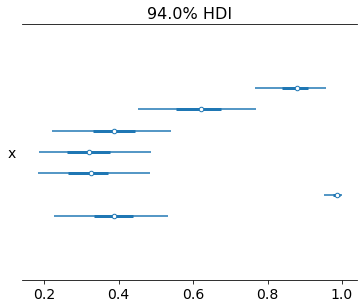

In [148]:
az.plot_forest(p_left.T);

In [128]:
idata['posterior']['1|actor'].to_numpy()[0]

(1000, 7)

### Accessing back-end objects

In [156]:
type(model.backend.model), model.backend.model

(pymc.model.Model,
      1|actor_sigma ~ N**+(0, 2.5)
     1|actor_offset ~ N(0, 1)
  1|treatment_sigma ~ N**+(0, 2.5)
 1|treatment_offset ~ N(0, 1)
            1|actor ~ Deterministic(f(1|actor_offset, 1|actor_sigma))
        1|treatment ~ Deterministic(f(1|treatment_offset, 1|treatment_sigma))
        pulled_left ~ Bern(f(1|treatment_offset, 1|treatment_sigma, 1|actor_offset, 1|actor_sigma)))

### Hierarchical Model

In [149]:
chimps.tail()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
499,7,4.0,1,6,64,1,1,1,4
500,7,6.0,1,6,66,1,1,1,4
501,7,3.0,1,6,68,0,0,1,3
502,7,7.0,1,6,70,0,0,1,3
503,7,2.0,1,6,72,0,0,1,3


In [150]:
hier_model = bmb.Model(
    "pulled_left ~ 0 + (1|actor) + (1|block) + (1|treatment)", 
    family='bernoulli',
    data=chimps
    )

model.build()

In [153]:
idata = hier_model.fit(inference_method='nuts_blackjax')

Modeling the probability that pulled_left==1


Compiling...
Compilation time =  0:00:02.008611
Sampling...
Sampling time =  0:00:03.845934
Transforming variables...
Transformation time =  0:00:00.641750


In [155]:
idata['sample_stats']['diverging'].to_numpy().sum()

4

In [154]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|actor_sigma,2.313,0.816,1.044,3.875,0.028,0.019,896.0,1840.0,1.0
1|block_sigma,0.242,0.210,0.000,0.600,0.006,0.005,1383.0,1988.0,1.0
1|treatment_sigma,0.698,0.450,0.125,1.560,0.014,0.010,1074.0,1672.0,1.0
1|actor[1],-0.475,0.412,-1.279,0.299,0.013,0.010,975.0,1529.0,1.0
1|actor[2],4.783,1.501,2.490,7.568,0.037,0.026,1738.0,2373.0,1.0
1|actor[3],-0.783,0.429,-1.592,-0.010,0.013,0.010,1046.0,1361.0,1.0
1|actor[4],-0.782,0.424,-1.596,0.009,0.013,0.010,996.0,1522.0,1.0
1|actor[5],-0.471,0.423,-1.288,0.297,0.014,0.010,968.0,1166.0,1.0
1|actor[6],0.472,0.422,-0.336,1.265,0.014,0.010,969.0,1279.0,1.0
1|actor[7],2.002,0.501,1.052,2.931,0.014,0.010,1284.0,1430.0,1.0
